In [93]:
import numpy as np
import cv2
import plotly.express as px
import plotly.graph_objects as go
import os
import pandas as pd

class Graph:
    #TODO implement 8-point connectivity
    def __init__(self, pixel, goal, value, g=0, parent=None):
        self.pixel = pixel
        self.goal = goal
        self.parent = parent
        self.neighbors = {'u' : None, #up
                          'l' : None, #left
                          'd' : None, #down
                          'r' : None  #right
                          }
        self.h = self.heuristic()
        self.g = g
        self.obstacle = value
        self.f = self.h + self.g + 1e4 * self.obstacle
    
    def heuristic(self):
        pixel_arr = np.array(self.pixel)
        goal_arr = np.array(self.goal)
        return np.linalg.norm(goal_arr - pixel_arr)

    def add_neighbor(self, loc, npixel, nvalue):
        self.neighbors[loc] = Graph(npixel, self.goal, nvalue, g=self.g+1, parent=self)


In [90]:
class A_star:
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.shape = grid.shape
        self.start = start
        self.goal = goal
        self.graph = Graph(start, goal, grid[start[0], start[1]])
        self.O = [] # priority queue
        self.C = set() # visited nodes
        self.T = []
        self.path = None

    def _gen_path(self, node):
        curr = node
        order = []
        while curr:
            order.append(curr.pixel)
            curr = curr.parent
        self.path = order[::-1]
    
    def run(self):
        self.O.append(self.graph)
        tt = 0
        test = set()
        #ncurr = self.graph
        #self.C.append(self.graph)

        #while ncurr.pixel != self.goal:
        while self.O:
            ncurr = self.O.pop()
            self.T.append(ncurr)
            if ncurr.pixel in test:
                print(tt)
                print(test)
            test.add(ncurr.pixel)

            if ncurr.pixel == self.goal:
                #self.C.append(ncurr)
                self.O = list(filter(lambda x: x.f < ncurr.g, self.O))
            
            elif ncurr not in self.C:
                #self.C.append(ncurr)
                self.C.add(ncurr.pixel)
                if not ncurr.pixel[0] % 1:
                    pass
                    #print(ncurr.pixel, end='::')
                    #print(len(self.C), len(self.O), end=' >< ')
                for i, loc in enumerate(ncurr.neighbors.keys()):
                    move = (-1)**(0 < i < 3) * np.array([0**((i + 1) % 2), 0**(i % 2)]) # x,y
                    #move = (-1)**(0 < i < 3) * np.array([-0**(i % 2), 0**((i + 1) % 2)])  # y, x
                    next_pixel = tuple(np.array(ncurr.pixel) + move)
                    #C_pxs = [node.pixel for node in self.C]
                    O_pxs = [node.pixel for node in self.O]

                    if (next_pixel not in self.C) and (next_pixel not in O_pxs):
                        if (next_pixel[0] >= 0 and next_pixel[1] >= 0) and (next_pixel[0] < self.shape[0] 
                            and next_pixel[1] < self.shape[1]):
                                nvalue = self.grid[next_pixel[0], next_pixel[1]]
                                ncurr.add_neighbor(loc, next_pixel, nvalue)
                                self.O.append(ncurr.neighbors[loc])
                
                self.O.sort(key=lambda x : x.f, reverse=True)
                if tt == 0:
                    print([(node.pixel, node.f) for node in self.O])
            #ncurr = self.O.pop()
            tt += 1
        self._gen_path(ncurr)



In [94]:
height, width = (16, 16) # in meters
scale = 28 # meters / pixel
def meters2pixels(coord):
    """Converts coordinate in meters to pixel coordinate.
    """
    xm, ym = coord
    xp = int(np.round(scale * (xm + width // 2)))
    yp = int(np.round(scale * (-ym + height // 2)))
    coord_pixels = (xp, yp)
    
    return coord_pixels

def pixels2meters(coord):
    """Converts pixels coordinate to coordinate in meters.
    """
    xp, yp = coord
    xm = xp / scale - width // 2
    ym = -yp / scale + height // 2
    coord_meters = (xm, ym)
    
    return coord_meters

grid_path = os.path.join('catkin_ws/src/wavefront', 'worlds/grid1.npy')
grid = np.load(grid_path)
#grid = cv2.transpose(grid)

start = (-6, 2)
start_ = meters2pixels(start)
goal = (5, 2)
goal_ = meters2pixels(goal)
mapa = grid.copy()

mapa[goal_[1], goal_[0]] = 2
mapa[start_[1], start_[0]] = 3
grid


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint64)

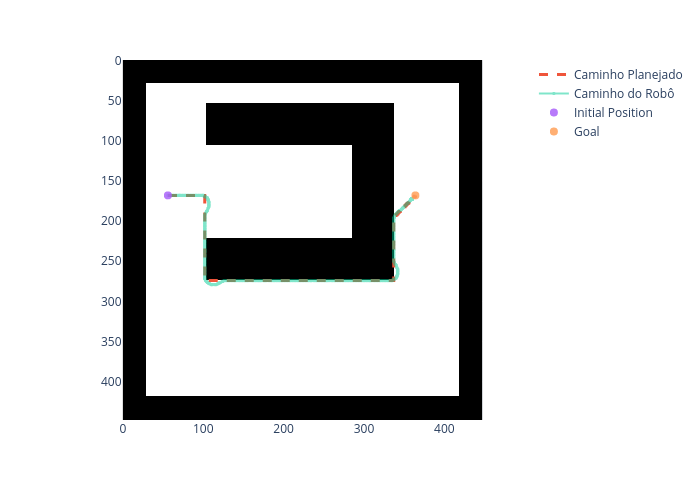

In [95]:
df = pd.read_csv('/home/fbartelt/Documents/UFMG/Planejamento/logs/astar_path.csv', index_col=0)
df2 = pd.read_csv('/home/fbartelt/Documents/UFMG/Planejamento/logs/astar_path2.csv', index_col=0)

aux = df2.to_numpy()
passed_px = [meters2pixels(x) for x in aux]
xpx, ypx = list(zip(*passed_px))

grid2 = cv2.imread('/home/fbartelt/Documents/UFMG/Planejamento/catkin_ws/src/Astar/worlds/maze.png', cv2.IMREAD_GRAYSCALE)
grid2 = cv2.resize(grid2, (450, 450), interpolation = cv2.INTER_AREA)
grid2 = 0**grid2.T
fig = px.imshow(0**grid.T, binary_string=True)
fig.add_trace(go.Scatter(x=df['1'], y=df['0'], name='Caminho Planejado', showlegend=True, line_width=3, line_dash='dash'))
fig.add_trace(go.Scatter(x=xpx, y=ypx, name='Caminho do Robô', showlegend=True, mode='lines+markers', marker_symbol='square-open', opacity=0.5, marker_size=2))
fig.add_trace(go.Scatter(x=[56], y=[168], name='Initial Position', mode='markers', marker_size=8, opacity=0.85))
fig.add_trace(go.Scatter(x=[364], y=[168], name='Goal', mode='markers', marker_size=8, opacity=0.85))
fig.show(renderer='png')

# Trapezoidal

In [32]:
height, width = (16, 16) # in meters
scale = 28 # meters / pixel

def meters2pixels(coord):
    """Converts coordinate in meters to pixel coordinate.
    """
    xm, ym = coord
    xp = int(np.round(scale * (xm + width // 2)))
    yp = int(np.round(scale * (-ym + height // 2)))
    coord_pixels = (xp, yp)
    
    return coord_pixels

def pixels2meters(coord):
    """Converts pixels coordinate to coordinate in meters.
    """
    xp, yp = coord
    xm = xp / scale - width // 2
    ym = -yp / scale + height // 2
    coord_meters = (xm, ym)
    
    return coord_meters

In [28]:
import plotly.express as px
import cv2
img = cv2.imread('trapz.png', cv2.IMREAD_GRAYSCALE)
img = img / 255
fig = px.imshow(img)
fig.show()

In [29]:
corners = [
           [4, 121], [31, 110], [39, 4], [48, 56], [58, 248], [81, 28], 
           [100, 183], [143, 101], [147, 215], [174, 104], [184, 250],
           [198, 7], [218, 97], [252, 80]
           ]
corners = [tuple(x) for x in corners]
for corner in corners:
    img[corner[1], corner[0]] = 2

fig = px.imshow(img)
fig.show()

In [24]:
img[1, 1]

1.0

***

# RRT

***

In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [273]:
height, width = (16, 16) # in meters
scale = 28 # meters / pixel

def meters2pixels(coord):
    """Converts coordinate in meters to pixel coordinate.
    """
    xm, ym = coord
    xp = int(np.round(scale * (xm + width // 2)))
    yp = int(np.round(scale * (-ym + height // 2)))
    coord_pixels = (xp, yp)
    
    return coord_pixels

def pixels2meters(coord):
    """Converts pixels coordinate to coordinate in meters.
    """
    xp, yp = coord
    xm = xp / scale - width // 2
    ym = -yp / scale + height // 2
    coord_meters = (xm, ym)
    
    return coord_meters

class Node:
    def __init__(self, pixel, parent=None):
        self.children = []
        self.pixel = pixel
        self.pos = pixels2meters(self.pixel)
        self.parent = parent

    def add_children(self, child):
        self.children.append(child)

class RRT:
    def __init__(self, root, grid, max_iter=1000):
        self.root = root
        self.grid = grid
        self.path = None
        self.max_iter = max_iter
    
    def gen_qrand(self, qgoal):
        free, counter = 0, 0
        rng = np.random.default_rng()
        goal_px = qgoal.pixel
        xg, yg = pixels2meters(goal_px)
        #x_inf, y_inf = meters2pixels((xg - margin, yg - margin))
        #x_sup, y_sup = meters2pixels((xg + margin, yg + margin))
        x_inf, y_inf = 0, 0
        x_sup, y_sup = self.grid.shape[0] - 1, self.grid.shape[1] - 1
        
        #x_inf, y_inf = np.minimum(np.maximum([x_inf, y_inf], [0, 0]), 
        #                         [self.grid.shape[0] - 1, self.grid.shape[1] - 1])
        #x_sup, y_sup = np.minimum(np.maximum([x_sup, y_sup], [0, 0]),
        #                         [self.grid.shape[0] - 1, self.grid.shape[1] - 1])

        xoptions = np.unique(np.linspace(x_inf, x_sup, dtype=np.int32))
        yoptions = np.unique(np.linspace(y_inf, y_sup, dtype=np.int32))

        while not free and counter <= self.max_iter:
            xrand = rng.choice(xoptions)
            yrand = rng.choice(yoptions)
            qrand = np.array([xrand, yrand])
            if self.grid[yrand, xrand] == 0:
                free = 1
            counter += 1

        return qrand

    def find_nearest_q(self, qrand):
        stack = self.root.children.copy()
        nearest_q = self.root
        qrand_pos = np.array(pixels2meters(qrand))
        min_dist = np.linalg.norm(qrand_pos - np.array(nearest_q.pos))

        while stack:
            #print([w.pixel for w in stack])
            node = stack.pop()
            x, y = node.pos
            curr_dist = np.linalg.norm(qrand_pos - [x, y])
            stack.extend(node.children.copy())
            
            if curr_dist <= min_dist:
                nearest_q = node
                min_dist = curr_dist
        
        return nearest_q
    
    def find_next_q(self, nearest_q, qrand):
        xrand, yrand = pixels2meters(qrand)
        near_pos = np.array(nearest_q.pos)
        next_vec = [xrand, yrand] - near_pos
        norm_vec = next_vec / (np.linalg.norm(next_vec) + 1e-3)
        next_qpx = meters2pixels(near_pos + 2 * norm_vec)
        #print(next_qpx)
        next_q = None
        collision = self.check_collision(nearest_q.pixel, next_qpx)
        #print(next_qpx)
        if not collision:
            next_q = Node(next_qpx, nearest_q)
        
        return next_q
    
    def check_collision(self, nearest_px, next_px):
        collision = 0
        xnxt_px, ynxt_px = pixels2meters(next_px)
        xnst_px, ynst_px = pixels2meters(nearest_px)
        x = np.array([xnst_px, xnxt_px])
        y = np.array([ynst_px, ynxt_px])
        
        if next_px[0] == nearest_px[0]:
            x, y = y, x
            xg = np.linspace(ynst_px, ynxt_px)
            A = np.vstack([x, np.ones(len(x))]).T
            m, c = np.linalg.lstsq(A, y, rcond=None)[0]
            yg = m * xg + c
            xg, yg = yg, xg
        else:
            xg = np.linspace(xnst_px, xnxt_px)
            A = np.vstack([x, np.ones(len(x))]).T
            m, c = np.linalg.lstsq(A, y, rcond=None)[0]

            yg = m * xg + c
        
        pixels = [meters2pixels(p) for p in list(zip(xg, yg))]

        for pixel in pixels:
            if self.grid[int(pixel[1]), int(pixel[0])] == 1:
                collision = 1
                break
            
        return collision

    
    def merge(self, qnew, tree):
        nearest_q = tree.find_nearest_q(qnew.pixel)
        xnew, ynew = pixels2meters(qnew.pixel)
        near_pos = np.array(nearest_q.pos)
        next_vec = [xnew, ynew] - near_pos
        path = []
        #print('m', np.linalg.norm(next_vec))
        norm_vec = next_vec / (np.linalg.norm(next_vec) + 1e-3)
        collision = tree.check_collision(nearest_q.pixel, qnew.pixel)
        if not collision:
            print('MERGED')
            print('qnew', qnew.pixel, ' merged with', nearest_q.pixel)
            
            for node in [nearest_q, qnew]:
                curr = node
                while curr:
                    path.append(curr.pixel)
                    curr = curr.parent
                path = path[::-1]

            self.path = path[::-1]
            tree.path = path
            
        return nearest_q, collision, path




In [282]:
def plot_RRT(grid, Tinit, Tgoal, plot_allNodes=False, plot_path=False):
    fig = px.imshow(1-grid, binary_string='True')
    fig.add_scatter(x=[Tgoal.root.pixel[0]],y=[Tgoal.root.pixel[1]], mode='markers', name='Goal')
    fig.add_scatter(x=[Tinit.root.pixel[0]],y=[Tinit.root.pixel[1]], mode='markers', name='Init')

    if plot_allNodes:
        name_dict = {0:'Tinit children', 1:'Tgoal children'}
        for idx, tree in enumerate([Tinit, Tgoal]):
            child_list = []
            stack = [tree.root]
            while stack:
                child = stack.pop()
                stack.extend(child.children.copy())
                child_list.extend(child.children.copy())

            pixels_ = [child.pixel for child in child_list]
            x, y = list(zip(*pixels_))
            fig.add_scatter(x=x, y=y, mode='markers', name=name_dict[idx])
    
    if plot_path:
        path = Tinit.path[::-1]
        for i in range(len(path) - 1):
            vec0 = np.array(path[i])
            vec1 = np.array(path[i + 1])
            fig.add_annotation(x=vec1[0], y=vec1[1], ax=vec0[0], ay=vec0[1],
                xref='x',yref='y',axref='x',ayref='y',text='', showarrow=True,
                arrowhead=3,arrowsize=1.8,arrowwidth=1,
                arrowcolor=px.colors.qualitative.Plotly[0]
                )
    
    fig.update_xaxes(range=[0, grid.shape[0]-1])
    fig.update_yaxes(range=[grid.shape[1]-1, 0])

    return fig
        


In [275]:
from collections import deque

qgoal = Node((356, 171))
q0 = Node((70, 171))
Tgoal = RRT(qgoal, grid)
Tinit = RRT(q0, grid)
trees = deque([Tinit, Tgoal])
counter, disc = 0, 1
pixels = []

while disc and counter < 5000:
    tree = trees[0]
    qrand = tree.gen_qrand(trees[1].root)
    qnearest = tree.find_nearest_q(qrand)
    qnext = tree.find_next_q(qnearest, qrand)

    if qnext:
        qnearest.add_children(qnext)
        nearest, collision, path = tree.merge(qnext, trees[1])
        #print(collision)
        #print(tree.root.pixel, trees[1].root.pixel)
        disc = collision
        pixels.append(qnext.pixel)
        
    counter += 1
    trees.rotate()
print(counter, disc)


MERGED
qnew (87, 233)  merged with (100, 312)
91 0


In [276]:
grid = np.load('catkin_ws/src/Astar/worlds/grid1.npy')
fig = plot_RRT(grid, Tinit, Tgoal, True, True)
fig.show()

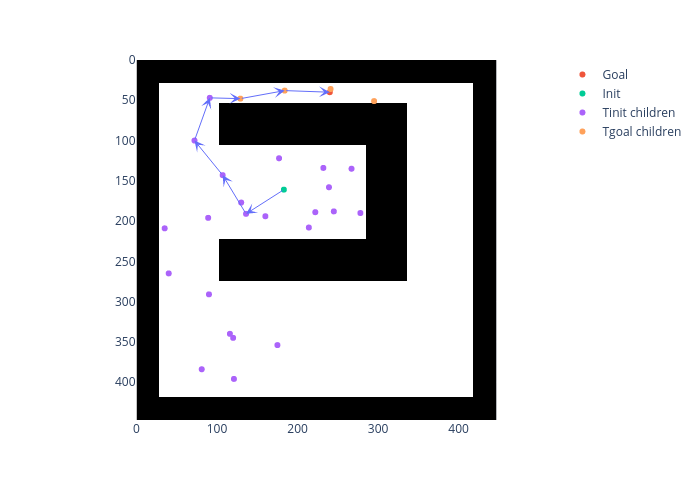

In [307]:
import pickle
with open('logs/RRTs.pickle', 'rb') as handle:
    pickled_trees = pickle.load(handle)
Tinit, Tgoal = pickled_trees
fig = plot_RRT(grid, Tinit, Tgoal, True, True)
fig.show(renderer='png')

In [305]:
# foto1 init:(-6, 2)       goal:(5, 2) ou (56, 168) x (364, 168)
# foto2 init:(-1.46, 2.25) goal:(6.36, 6.29) ou (265, 161) x (402, 48)
pixels2meters((240, 40))

(0.5714285714285712, 6.571428571428571)